# Import Library

In [1]:
import wget
import zipfile
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tkinter as tk

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from PIL import Image, ImageTk
from tkinter import filedialog

# Data Collection

Get data from Github

In [24]:
def download_file_if_not_exists(url, file_name):
    if not os.path.exists(file_name):
        wget.download(url)
        print("File downloaded successfully!")
    else:
        print("File has already been downloaded!")

File has already been downloaded!


In [ ]:
url = "https://github.com/dicodingacademy/assets/releases/download/release/rockpaperscissors.zip"
file_name = "rockpaperscissors.zip"
download_file_if_not_exists(url, file_name)

Extract ZIP file

In [25]:
def extract_zipfile(zip_file, extract_to):
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

In [26]:
if __name__ == '__main__':
    zip_file = 'rockpaperscissors.zip'
    extract_to = 'rockpaperscissors'

    if not os.path.exists(extract_to):
        os.makedirs(extract_to)
        extract_zipfile(zip_file=zip_file, extract_to=extract_to)
    else:
        print('Data has been extracted!.')

Data has been extracted!.


# Data Preprocessing

In [27]:
def preprocess_images(folder_path, img_size=(150, 150)):
    images = []
    labels = []
    for label, category in enumerate(['rock', 'paper', 'scissors']):
        category_path = os.path.join(folder_path, category)
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, img_size)
            img = img / 255.0
            # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)

In [28]:
folder_path = "rockpaperscissors/rockpaperscissors/rps-cv-images"
images, labels = preprocess_images(folder_path)

In [29]:
images, labels = shuffle(images, labels, random_state=42)

Split data into train and test

In [30]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.4, random_state=42)

Create image generator

In [31]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

In [32]:
batch_size = 32

In [33]:
train_generator = datagen.flow(X_train, y_train, batch_size=batch_size)

In [34]:
test_generator = datagen.flow(X_test, y_test, batch_size=batch_size)

Visualize image augmentation

In [35]:
def visualize_augmented_images(datagen, sample_images, augmentation_names):
    plt.figure(figsize=(12, 10))
    for i, sample_image in enumerate(sample_images):
        sample_image = np.expand_dims(sample_image, axis=0)
        augmented_images = [sample_image]
        for j in range(len(augmentation_names) - 1):
            x_batch = datagen.flow(sample_image, batch_size=1)[0]
            augmented_images.append(x_batch)

        for j in range(len(augmented_images)):
            plt.subplot(len(sample_images), len(augmentation_names), i * len(augmentation_names) + j + 1)
            plt.imshow(augmented_images[j][0])
            if i == 0:
                plt.title(augmentation_names[j])
            plt.axis('off')
    plt.tight_layout()
    plt.show()

In [36]:
sample_images = [X_train[np.random.choice(np.where(y_train == label)[0])] for label in np.unique(y_train)[:3]]

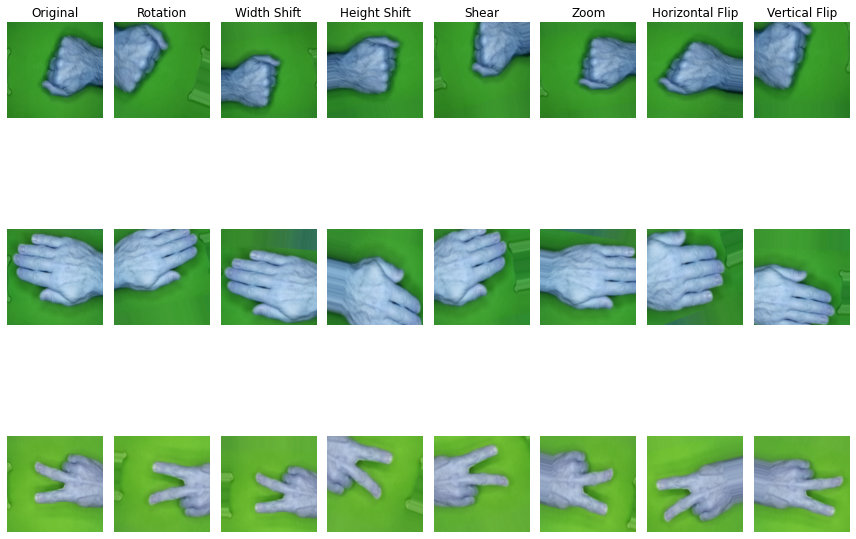

In [37]:
visualize_augmented_images(datagen, sample_images, ['Original', 'Rotation', 'Width Shift', 'Height Shift',
                                                    'Shear', 'Zoom', 'Horizontal Flip', 'Vertical Flip'])

Show number of train and test data

In [38]:
print("Number of training samples:", len(X_train))
print("Number of test samples:", len(X_test))

Number of training samples: 1312
Number of test samples: 876


# Modeling

Apply sequential model

In [39]:
INPUT_IMG_SHAPE = (150, 150, 3)
NUM_CLASSES = 3

In [40]:
sequential_model = tf.keras.models.Sequential()

In [41]:
sequential_model.add(tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=(3, 3),
    activation='relu',
    input_shape=INPUT_IMG_SHAPE
))
sequential_model.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2)
))

sequential_model.add(tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=(3, 3),
    activation='relu'
))
sequential_model.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2)
))

sequential_model.add(tf.keras.layers.Conv2D(
    filters=128,
    kernel_size=(3, 3),
    activation='relu'
))

sequential_model.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2)
))

sequential_model.add(tf.keras.layers.Conv2D(
    filters=128,
    kernel_size=(3, 3),
    activation='relu'
))

sequential_model.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2)
))

sequential_model.add(tf.keras.layers.Flatten())
sequential_model.add(tf.keras.layers.Dropout(0.5))

sequential_model.add(tf.keras.layers.Dense(
    units=512,
    activation='relu'
))

sequential_model.add(tf.keras.layers.Dense(
    units=NUM_CLASSES,
    activation='softmax'
))

In [42]:
sequential_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

Add first-order optimization algorithm

In [43]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

sequential_model.compile(optimizer=adam_optimizer,
                         loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                         metrics=['accuracy'])

In [44]:
train_steps_per_epoch = len(X_train) // batch_size
test_steps = len(X_test) // batch_size

print('Train steps per epoch: ', train_steps_per_epoch)
print('Test steps: ', test_steps)

Train steps per epoch:  41
Test steps:  27


Create callbacks

In [45]:
class CustomerCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        if logs.get('accuracy') > 0.96:
            self.model.stop_training = True
            print('\nThe accuracy threshold has been achieved, more than 96%!')

In [46]:
checkpoint_filepath = 'best_model.keras'

checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
                             save_weights_only=False,
                             monitor='val_accuracy',
                             mode='max',
                             save_best_only=True)

Fit the model

In [47]:
history = sequential_model.fit(x=train_generator,
                               validation_data=test_generator,
                               epochs=20,
                               steps_per_epoch=train_steps_per_epoch,
                               validation_steps=test_steps,
                               verbose=1,
                               callbacks=[checkpoint, CustomerCallback()])

Epoch 1/20
41/41 [==============================] - 30s 699ms/step - loss: 1.0942 - accuracy: 0.3773 - val_loss: 1.0738 - val_accuracy: 0.4016
Epoch 2/20
41/41 [==============================] - 27s 651ms/step - loss: 0.8765 - accuracy: 0.5960 - val_loss: 0.5976 - val_accuracy: 0.7778
Epoch 3/20
41/41 [==============================] - 27s 661ms/step - loss: 0.5663 - accuracy: 0.7736 - val_loss: 0.5483 - val_accuracy: 0.7836
Epoch 4/20
41/41 [==============================] - 27s 664ms/step - loss: 0.5002 - accuracy: 0.7873 - val_loss: 0.4378 - val_accuracy: 0.8264
Epoch 5/20
41/41 [==============================] - 27s 670ms/step - loss: 0.4381 - accuracy: 0.8285 - val_loss: 0.3695 - val_accuracy: 0.8542
Epoch 6/20
41/41 [==============================] - 28s 684ms/step - loss: 0.3756 - accuracy: 0.8575 - val_loss: 0.3348 - val_accuracy: 0.8704
Epoch 7/20
41/41 [==============================] - 28s 672ms/step - loss: 0.3273 - accuracy: 0.8796 - val_loss: 0.3110 - val_accuracy: 0.8958

# Evaluation

Visualize the loss and accuracy score

In [48]:
def render_training_history(training_history):
    """
    Renders the training history with loss and accuracy plots.
    """
    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']
    accuracy = training_history.history['accuracy']
    val_accuracy = training_history.history['val_accuracy']

    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.plot(val_loss, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(accuracy, label='Training set')
    plt.plot(val_accuracy, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.show()

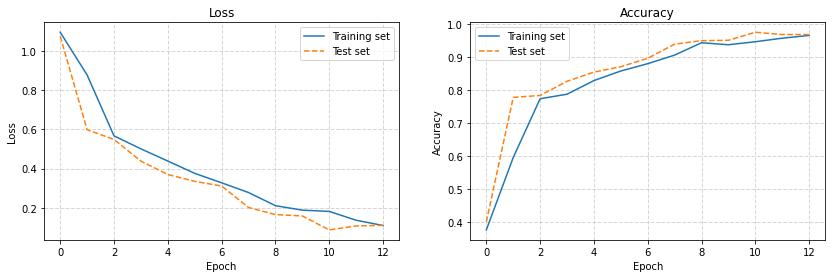

In [49]:
render_training_history(history)

Get the loss and accuracy score from train and test data

In [50]:
train_loss, train_accuracy = sequential_model.evaluate(train_generator)

41/41 [==============================] - 8s 186ms/step - loss: 0.0909 - accuracy: 0.9756


In [51]:
test_loss, test_accuracy = sequential_model.evaluate(test_generator)

28/28 [==============================] - 5s 180ms/step - loss: 0.0951 - accuracy: 0.9806


In [52]:
overall_loss = (train_loss * train_generator.n + test_loss * test_generator.n) / (train_generator.n + test_generator.n)
overall_accuracy = (train_accuracy * train_generator.n + test_accuracy * test_generator.n) / (train_generator.n + test_generator.n)

In [53]:
print('Train data loss:', train_loss)
print('Train data accuracy:', train_accuracy)
print('')
print('Test data loss:', test_loss)
print('Test data accuracy:', test_accuracy)
print('')
print('Overall loss:', overall_loss)
print('Overall accuracy:', overall_accuracy)

Train data loss: 0.09089311957359314
Train data accuracy: 0.9756097793579102

Test data loss: 0.09510531276464462
Test data accuracy: 0.9805936217308044

Overall loss: 0.09257953695721338
Overall accuracy: 0.9776051385529081


In [54]:
y_pred = sequential_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

28/28 [==============================] - 3s 95ms/step


Visualize the confusion matrix

In [55]:
conf_matrix = confusion_matrix(y_test, y_pred_classes)

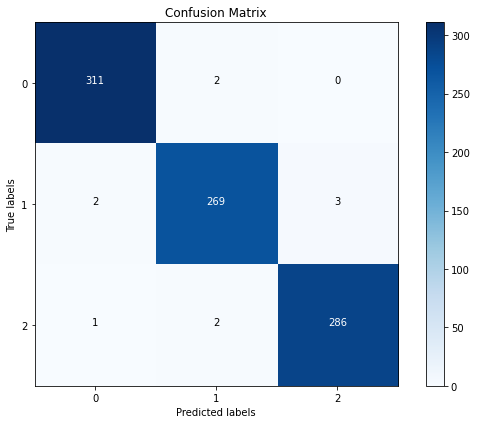

In [56]:
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_test)))
plt.xticks(tick_marks, np.unique(y_test))
plt.yticks(tick_marks, np.unique(y_test))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

# Prediction

Load best model

In [3]:
def load_model(model_path):
    model = tf.keras.models.load_model(model_path)
    return model

In [4]:
model = load_model('best_model.keras')

Data preprocessing

In [5]:
def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((150, 150))  
    img = np.array(img) / 255.0
    img = np.expand_dims(img, axis=0) 
    return img

In [6]:
root = tk.Tk()
root.title("Rock Paper Scissors Prediction")

''

In [7]:
select_button = tk.Button(root, text="Select Image", command=predict_image)
select_button.pack(pady=20)

In [9]:
result_label = tk.Label(root, text="")
result_label.pack()

In [10]:
image_label = tk.Label(root)
image_label.pack()

In [12]:
def predict_image():
    file_path = filedialog.askopenfilename()

    preprocessed_img = preprocess_image(file_path)

    prediction = model.predict(preprocessed_img)
    class_names = ['rock', 'paper', 'scissors']
    predicted_class_index = np.argmax(prediction)
    predicted_class = class_names[predicted_class_index]
    probability = prediction[0][predicted_class_index]

    result_label.config(text=f"Prediction: {predicted_class}, Probability: {probability:.2f}")

    img = Image.open(file_path)
    img = img.resize((300, 300))  # Resize the image for display
    img = ImageTk.PhotoImage(img)
    image_label.config(image=img)
    image_label.image = img

In [11]:
root.mainloop()

1/1 [==============================] - 0s 41ms/step
